# Programming in Python
## Exam: June 10, 2025


You can solve the exercises below by using standard Python 3.12 libraries, NumPy, Matplotlib, Pandas, PyMC.
You can browse the documentation: [Python](https://docs.python.org/3.12/), [NumPy](https://numpy.org/doc/1.26/index.html), [Matplotlib](https://matplotlib.org/3.10.0/users/index.html), [Pandas](https://pandas.pydata.org/pandas-docs/version/2.2/index.html), [PyMC](https://www.pymc.io/projects/docs/en/stable/api.html).
You can also look at the [slides](https://homes.di.unimi.it/monga/lucidi2425/pyqb00.pdf) or your code on [GitHub](https://github.com).


**The exam is "open book", but it is strictly forbidden to communicate with others or "ask questions" online (i.e., stackoverflow is ok if the answer is already there, but you cannot ask a new question or use ChatGPT and similar products). Suspicious canned answers or plagiarism among student solutions will cause the invalidation of the exam for all the people involved.**

To test examples in docstrings use

```python
import doctest
doctest.testmod()
```

**SOLVE EACH EXERCISE IN ONE OR MORE NOTEBOOK CELLS AFTER THE QUESTION.**

In [1]:
import numpy as np
import pandas as pd  # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pymc as pm   # type: ignore
import arviz as az  # type: ignore

### Exercise 1 (max 3 points)

The file [rhinos.csv](./rhinos.csv) (Duthé, Vanessa (2023), Reductions in home-range size and social interactions among dehorned black rhinoceroses (Diceros bicornis), Dryad, Dataset, https://doi.org/10.5061/dryad.gf1vhhmt5) contains:

- Date: date of rhino sighting
- RhinosAtSighting: id of individual rhino
- Sex: sex of individual rhino
- Horn: indicating horned or dehorned rhino at time of sighting
- DateBorn: date of birth of individual rhino
- Reserve: reserve where sighting occured

Read the data in a pandas DataFrame. Be sure  that the columns `Date` and `DateBorn` has dtype `pd.datetime64[ns]`.


In [2]:
df=pd.read_csv('rhinos.csv',sep=';', parse_dates=['Date','DateBorn'],dayfirst=True)
df.head()

,Date,RhinosAtSighting,Sex,Horn,DateBorn,Reserve
0,2019-03-31,MPGRBF-02-05,Female,Dehorned,1998-01-01,Reserve1
1,2015-03-17,MPGRBF-02-05,Female,Horned,1998-01-01,Reserve1
2,2016-02-06,MPGRBF-02-05,Female,Horned,1998-01-01,Reserve1
3,2018-06-20,MPGRBF-02-05,Female,Dehorned,1998-01-01,Reserve1
4,2018-01-02,MPGRBF-02-05,Female,Dehorned,1998-01-01,Reserve1


### Exercise 2 (max 3 points)

Add a column `Age` with the age in weeks of the rhinos at the time of the sighting.


In [3]:
df['Age'] = (df['Date'] - df['DateBorn']).dt.days / 7

### Exercise 3 (max 7 points)

Define a function `dehornings` that takes a list of sightings "Horned" or "Dehorned" and counts how many times the rhino was dehorned.
For example, if the sightings are `["Horned", "Horned", "Dehorned"]`, the rhino was dehorned once; if the sightings are `["Dehorned", "Dehorned", "Dehorned"]` the rhino was dehorned once; if the sightings are `["Horned", "Horned", "Horned", "Horned"]` the rhino was never dehorned; if the sightings are `["Dehorned", "Horned", "Dehorned"]` the rhino was dehorned two times.

To get the full marks, you should declare correctly the type hints and add a test within a doctest string.

In [4]:
def dehornings(sightings):
    count = 0
    prev = None
    for sighting in sightings:
        if sighting == "Dehorned" and prev != "Dehorned":
            count += 1
        prev = sighting
    return count
dehornings(["Horned","Horned","Dehorned"])       

1

### Exercise 4 (max 5 points)

Apply the function defined in Exercise 3 to the data referring to the rhinos and find the rhino that was dehorned the most. Please note that you should order the list of sightings by `Date`.

In [5]:
def find_most_dehorned_rhino(df):
    grouped = df.groupby('RhinosAtSighting').apply(
    lambda x:x.sort_values('Date')['Horn'].tolist()
    )
    dehorned_counts=grouped.apply(dehornings)
    most_dehorned=dehorned_counts.idxmax()
    return most_dehorned
print(find_most_dehorned_rhino(df))

xWF22


### Exercise 5 (max 2 points)

Compute for each rhino the weeks between the first and the last sighting.

In [6]:
weeks=(df.groupby('RhinosAtSighting')['Date']
      .agg(lambda x:(x.max()-x.min()).days//7)
      )
print(weeks)

RhinosAtSighting
Bonakala      425
Bongumenzi    231
Cusha         711
Dondo         305
Dumisane      306
             ... 
xWF22         374
xWF30         164
xWF5          432
xWF6          227
xWF7          434
Name: Date, Length: 368, dtype: int64


### Exercise 6 (max 4 points)

Plot a histogram of the number of rhinos observed in each reserve

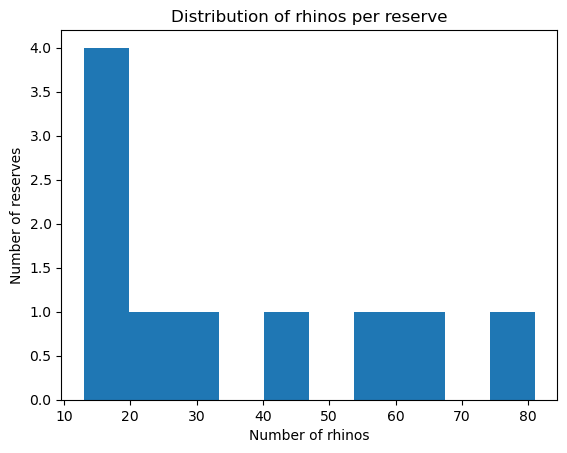

In [7]:
rhinos_count_per_reserve=df.groupby('Reserve')['RhinosAtSighting'].nunique()
plt.hist(rhinos_count_per_reserve.values,bins=10)
plt.xlabel('Number of rhinos')
plt.ylabel('Number of reserves')
plt.title('Distribution of rhinos per reserve')
plt.show()

### Exercise 7 (max 4 points)

Plot together the histograms of the number of male and female rhinos observed in each reserve

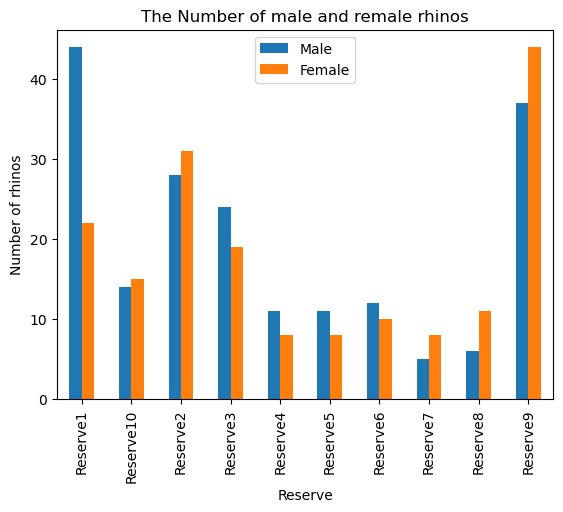

In [8]:
male_rhinos=df[df['Sex']=='Male'].groupby('Reserve')['RhinosAtSighting'].nunique()
famale_rhinos=df[df['Sex']=='Female'].groupby('Reserve')['RhinosAtSighting'].nunique()
counts_rhinos=pd.DataFrame({'Male':male_rhinos,'Female':famale_rhinos}).fillna(0)
counts_rhinos.plot(kind='bar')
plt.xlabel('Reserve')
plt.ylabel('Number of rhinos')
plt.title('The Number of male and remale rhinos')
plt.show()

### Exercise 8 (max 5 points)

Consider this statistical model:

- a parameter $\alpha$ is normally distributed with mean 0 and standard deviation 2.
- a parameter $\beta$ is normally distributed with mean 0 and standard deviation 2.
- $\sigma$ is exponentially distributed with $\lambda = 1$
- the observed mean number of dehorned sightings for each `Reserve` is normally distributed with a standard deviation of $\sigma$ and a mean given by $\alpha + \beta\cdot N$, where $N$ is number of (unique) rhinos in the reserve.

Code this model with pymc, sample the model, and plot the summary of the resulting estimation by using `az.plot_posterior`.





In [9]:
# Step 1: 导入包
import pymc as pm
import numpy as np
import arviz as az

# 假数据/必要输入：可以用占位，比如mean_counts、N_rhinos
# mean_counts = 保护区去角目击均值, N_rhinos = 保护区犀牛去重数
# 可用下面示例来注释
# mean_counts = np.array([...])  # 每个保护区的观测均值
# N_rhinos = np.array([...])     # 相应保护区的犀牛数

# Step 2: 定义建模过程
with pm.Model() as model:
    # α ~ Normal(0, 2)
    alpha = pm.Normal('alpha', mu=0, sigma=2)
    # β ~ Normal(0, 2)
    beta = pm.Normal('beta', mu=0, sigma=2)
    # σ ~ Exponential(1)
    sigma = pm.Exponential('sigma', lam=1)
    
    # 均值：alpha + beta * N，每个reserve一个
    # 预测值 mean_pred
    # mean_pred = alpha + beta * N_rhinos
    # 观测值 likelihood：Normal(mean_pred, sigma)
    # pm.Normal('obs', mu=mean_pred, sigma=sigma, observed=mean_counts)
    
    pass  # 这里可以注释：数据填充后，下一行取消pass并填上likelihood定义
    
    # Step 3: 采样
    # trace = pm.sample(1000, return_inferencedata=True)
    pass  # 没实际数据的话用pass占位，并注释说明
    
    # Step 4: 可视化后验分布
    # az.plot_posterior(trace)
    pass  # 占位

# 注明: 没有实际数据输入这里只能写结构和关键步骤，见上每步注释。